In [1]:
from pathlib import Path
from IPython.display import HTML, display
css = Path("../../../css/custom.css").read_text(encoding="utf-8")
display(HTML(f"<style>{css}</style>"))


# Chapter 2 — Basics of Data and Preprocessing
## Lesson 8: Data Collection and Label Quality (Noise, Ambiguity, Measurement Error)

### Learning objectives

By the end of this lesson you will be able to:

1. Separate **label noise**, **label ambiguity**, and **feature measurement error** as distinct sources of model risk.
2. Represent label corruption using a noise channel $T$ and interpret what it means operationally.
3. Measure ambiguity via **repeat labeling** and agreement statistics (Cohen’s $\kappa$).
4. Build a **label-audit queue** using disagreement and model signals (loss, low confidence).
5. Understand why accuracy alone can be misleading under label noise (calibration and AUC effects).
6. Quantify how feature measurement error causes attenuation in regression and separability loss in classification.

This lesson focuses on *data-centric* controls that often outperform algorithmic changes when labels are the bottleneck.


### 1) Data collection is a process, not a file

In production, a dataset is the output of a system:

- A real-world process (customers, devices, markets).
- Instrumentation (sensors, logs, forms).
- ETL and joins.
- Feature computation and aggregation.
- Label construction (human labeling, outcomes, heuristics).

A clean abstraction is a latent/observed model:

- Latent “true” features: $x$
- Observed features: $x^{*}$
- Latent label: $y$
- Observed label: $\tilde{y}$

General form:

$$
x^{*} = g(x, u), \qquad \tilde{y} \sim \mathbb{P}(\tilde{y} \mid y, x)
$$

where $u$ is measurement error. Many ML failures are failures of this system, not of the estimator.


### 2) Label noise taxonomy via a transition matrix

For $K$ classes, define a (possibly instance-dependent) transition matrix:

$$
T_{ij}(x) = \mathbb{P}(\tilde{y}=j \mid y=i, x)
$$

Key regimes:

- **Symmetric noise:** with probability $\eta$, the label flips uniformly to one of the other classes.
- **Class-conditional noise:** the flip pattern depends on the class $i$ but not on $x$.
- **Instance-dependent noise:** the flip probability depends on $x$ (hard examples flip more).

Operational interpretation: $T$ encodes the “confusion behavior” of your labeling process.


### 3) Noisy risk under symmetric flips (binary 0–1 loss)

Binary labels $y\in\{-1,+1\}$, observed labels $\tilde{y}$ flipped with probability $\eta\in[0,1/2)$:

$$
\tilde{y}=
\begin{cases}
y, & \text{with probability } 1-\eta \\
-y, & \text{with probability } \eta
\end{cases}
$$

Define clean risk:

$$
R(f)=\mathbb{P}(f(x)\neq y)
$$

and noisy risk:

$$
R_{\eta}(f)=\mathbb{P}(f(x)\neq \tilde{y})
$$

Then:

$$
R_{\eta}(f)=\eta+(1-2\eta)R(f)
$$

Because $(1-2\eta)>0$, minimizing $R_{\eta}$ is equivalent to minimizing $R$ **for 0–1 loss**.  
However, in practice we train with surrogate losses (log-loss, hinge), so probability quality and calibration can degrade even if accuracy remains similar.


### 4) Ambiguity is not noise

Ambiguity occurs when there is no crisp single label:

- Edge cases not specified by the label policy.
- Inherently stochastic or multi-causal outcomes.
- Forced single-label for a multi-label phenomenon.

A practical remedy is **repeat labeling**:

- Two annotators provide $y^{(A)}$ and $y^{(B)}$ independently.
- Disagreement identifies ambiguous regions and guideline gaps.

Cohen’s $\kappa$ corrects for chance agreement:

- Observed agreement: $p_o$
- Expected chance agreement: $p_e$

$$
\kappa = \frac{p_o - p_e}{1 - p_e}
$$

Low $\kappa$ can indicate poor guidelines, insufficient training, or an intrinsically ambiguous task definition.


### 5) Measurement error in features

In regression with a single feature:

$$
y=\beta_0+\beta_1 x+\varepsilon,\quad \mathbb{E}[\varepsilon]=0
$$

but you observe:

$$
x^{*}=x+u,\quad \mathbb{E}[u]=0
$$

The estimated slope tends to shrink (attenuation). A useful approximation:

$$
\hat{\beta}_1^{*}\approx \beta_1\cdot\frac{\mathrm{Var}(x)}{\mathrm{Var}(x)+\mathrm{Var}(u)}
$$

In classification, measurement error reduces separability by adding overlap between class-conditional distributions.


### 6) Practical controls: improving labels is an engineering program

A minimal label-quality program includes:

1. Label policy document with edge cases.
2. Annotator training + quizzes + feedback loops.
3. Sampling plan to cover rare/high-impact slices.
4. Repeat labeling on a rotating audit set.
5. Adjudication process for disagreements.
6. Continuous monitoring of agreement ($\kappa$), audit-yield, and downstream KPI shifts.
7. Versioning for label policy changes.

Below, we build hands-on diagnostics using multiple datasets from your repository structure.


### 7) Experiments in this notebook

We will:

- Load multiple datasets using repository-relative paths.
- Inject label noise and measure degradation.
- Simulate repeat labeling and compute $\kappa$.
- Construct an audit queue from disagreement + model loss.
- Compare clean vs noisy label training for calibration.
- Add feature measurement error and observe attenuation and performance loss.


In [2]:
# Imports
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LinearRegression

from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay,
    mean_squared_error, roc_auc_score
)
from sklearn.calibration import calibration_curve

np.random.seed(42)


In [3]:
# Dataset registry (repository-relative paths)
DATASETS = {
    "diabetes": {"path": "../../../Datasets/Classification/diabetes.csv", "target": "classification", "kind": "binary_text"},
    "drug200": {"path": "../../../Datasets/Classification/drug200.csv", "target": "Drug", "kind": "multiclass"},
    "iris": {"path": "../../../Datasets/Classification/iris.csv", "target": "classification", "kind": "multiclass"},
    "wine_quality": {"path": "../../../Datasets/Classification/Wine_Quality.csv", "target": "quality", "kind": "ordinal"},
    "house_prices": {"path": "../../../Datasets/Regression/house-prices.csv", "target": "Price", "kind": "regression"},
    "complaints": {"path": "../../../Datasets/Clustering/ConsumerComplaints.csv", "target": "Timely Response", "kind": "binary_text"},
}

rng = np.random.default_rng(2026)
multi_key = rng.choice(["iris", "drug200"])
bin_key = rng.choice(["diabetes", "wine_quality", "complaints"])
reg_key = rng.choice(["house_prices"])

def load_df(key):
    meta = DATASETS[key]
    df = pd.read_csv(meta["path"])
    return df, meta

df_multi, meta_multi = load_df(multi_key)
df_bin, meta_bin = load_df(bin_key)
df_reg, meta_reg = load_df(reg_key)

print("Chosen datasets:")
print("  multi-class:", multi_key, df_multi.shape)
print("  binary-ish :", bin_key, df_bin.shape)
print("  regression :", reg_key, df_reg.shape)

display(df_multi.head())
display(df_bin.head())
display(df_reg.head())


Chosen datasets:
  multi-class: drug200 (200, 6)
  binary-ish : diabetes (768, 9)
  regression : house_prices (128, 8)


,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,classification
0,6,148,72,35,0,33.6,0.627,50,Diabetic
1,1,85,66,29,0,26.6,0.351,31,Non-Diabetic
2,8,183,64,0,0,23.3,0.672,32,Diabetic
3,1,89,66,23,94,28.1,0.167,21,Non-Diabetic
4,0,137,40,35,168,43.1,2.288,33,Diabetic


,Home,Price,SqFt,Bedrooms,Bathrooms,Offers,Brick,Neighborhood
0,1,114300,1790,2,2,2,No,East
1,2,114200,2030,4,2,3,No,East
2,3,114800,1740,3,2,1,No,East
3,4,94700,1980,3,2,3,No,East
4,5,119800,2130,3,3,3,No,East


In [4]:
# Helpers: split columns and show target distribution
def split_cols(X):
    cat = [c for c in X.columns if X[c].dtype == "object"]
    num = [c for c in X.columns if c not in cat]
    return num, cat

def summarize_target(df, target):
    vc = df[target].value_counts(dropna=False)
    return pd.DataFrame({"count": vc, "pct": (vc / len(df)).round(4)})

print("Multi-class target distribution:")
display(summarize_target(df_multi, meta_multi["target"]).head(20))

print("Binary-ish target distribution (raw):")
display(summarize_target(df_bin, meta_bin["target"]).head(20))

print("Regression target summary:")
display(df_reg[meta_reg["target"]].describe())


Multi-class target distribution:


,count,pct
Drug,,
DrugY,91,0.455
drugX,54,0.270
drugA,23,0.115
drugC,16,0.080
drugB,16,0.080


Binary-ish target distribution (raw):


,count,pct
classification,,
Non-Diabetic,500,0.651
Diabetic,268,0.349


Regression target summary:


count       128.000000
mean     130427.343750
std       26868.770371
min       69100.000000
25%      111325.000000
50%      125950.000000
75%      148250.000000
max      211200.000000
Name: Price, dtype: float64

In [5]:
# Noise injection utilities
def inject_symmetric_noise(y, noise_rate=0.2, seed=0):
    rng = np.random.default_rng(seed)
    y = np.asarray(y)
    classes = np.unique(y)
    y_noisy = y.copy()
    flip = rng.random(len(y)) < noise_rate
    for i in np.where(flip)[0]:
        other = classes[classes != y[i]]
        y_noisy[i] = rng.choice(other)
    return y_noisy, flip

def inject_class_conditional_noise(y, noise_rate=0.2, seed=0):
    rng = np.random.default_rng(seed)
    y = np.asarray(y)
    classes = np.unique(y)
    order = list(sorted(classes))
    idx = {c:i for i,c in enumerate(order)}
    y_noisy = y.copy()
    flip = rng.random(len(y)) < noise_rate
    for i in np.where(flip)[0]:
        j = idx[y[i]]
        y_noisy[i] = order[(j + 1) % len(order)]
    return y_noisy, flip

def inject_binary_flip(y01, noise_rate=0.25, seed=0):
    rng = np.random.default_rng(seed)
    y = np.asarray(y01).astype(int).copy()
    flip = rng.random(len(y)) < noise_rate
    y[flip] = 1 - y[flip]
    return y, flip


Baseline accuracy: 0.92
              precision    recall  f1-score   support

       DrugY     0.8800    0.9565    0.9167        23
       drugA     1.0000    1.0000    1.0000         6
       drugB     1.0000    0.5000    0.6667         4
       drugC     1.0000    1.0000    1.0000         4
       drugX     0.9231    0.9231    0.9231        13

    accuracy                         0.9200        50
   macro avg     0.9606    0.8759    0.9013        50
weighted avg     0.9248    0.9200    0.9150        50



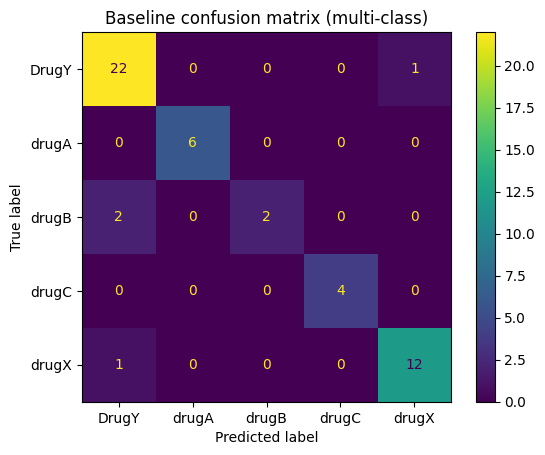

,noise_rate,acc_symmetric,acc_class_cond
0,0.00,0.92,0.92
1,0.10,0.96,0.90
2,0.20,0.80,0.80
3,0.35,0.78,0.74
4,0.50,0.68,0.52


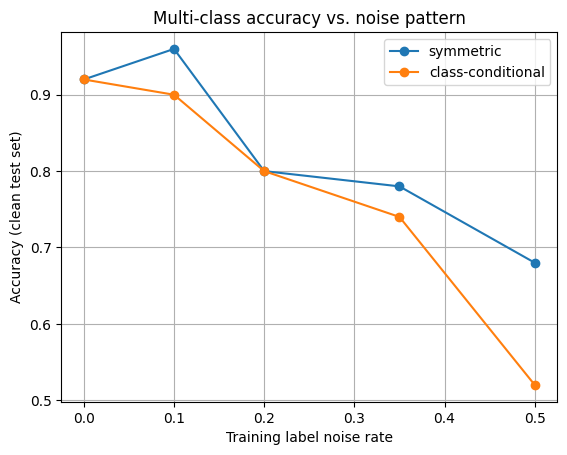

In [6]:
# Experiment A: multi-class degradation under label noise
df = df_multi.copy()
target = meta_multi["target"]

X = df.drop(columns=[target])
y = df[target].astype(str)

num_cols, cat_cols = split_cols(X)

pre = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("sc", StandardScaler())]), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ],
    remainder="drop"
)
base_model = Pipeline([("pre", pre), ("lr", LogisticRegression(max_iter=3000))])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

base_model.fit(X_train, y_train)
pred = base_model.predict(X_test)

print("Baseline accuracy:", accuracy_score(y_test, pred))
print(classification_report(y_test, pred, digits=4))

cm = confusion_matrix(y_test, pred, labels=np.unique(y))
ConfusionMatrixDisplay(cm, display_labels=np.unique(y)).plot(values_format="d")
plt.title("Baseline confusion matrix (multi-class)")
plt.show()

rows = []
for r in [0.0, 0.1, 0.2, 0.35, 0.5]:
    y_sym, _ = inject_symmetric_noise(y_train, r, seed=1)
    y_cc, _ = inject_class_conditional_noise(y_train, r, seed=2)

    m_sym = Pipeline([("pre", pre), ("lr", LogisticRegression(max_iter=3000))])
    m_cc = Pipeline([("pre", pre), ("lr", LogisticRegression(max_iter=3000))])

    m_sym.fit(X_train, y_sym)
    m_cc.fit(X_train, y_cc)

    rows.append({
        "noise_rate": r,
        "acc_symmetric": accuracy_score(y_test, m_sym.predict(X_test)),
        "acc_class_cond": accuracy_score(y_test, m_cc.predict(X_test)),
    })

resA = pd.DataFrame(rows)
display(resA)

plt.figure()
plt.plot(resA["noise_rate"], resA["acc_symmetric"], marker="o", label="symmetric")
plt.plot(resA["noise_rate"], resA["acc_class_cond"], marker="o", label="class-conditional")
plt.xlabel("Training label noise rate")
plt.ylabel("Accuracy (clean test set)")
plt.title("Multi-class accuracy vs. noise pattern")
plt.grid(True)
plt.legend()
plt.show()


Observed agreement p_o: 0.7467
Cohen's kappa:        0.6450


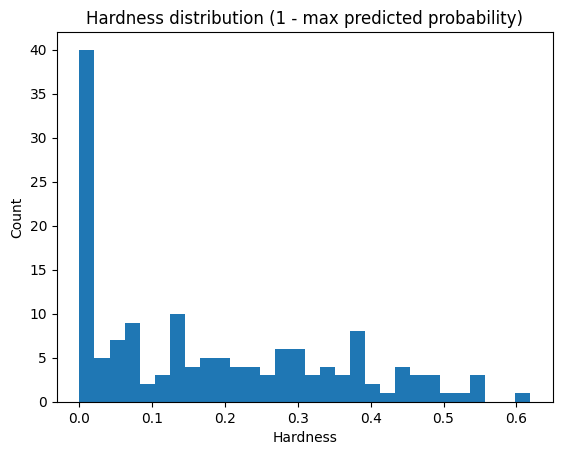

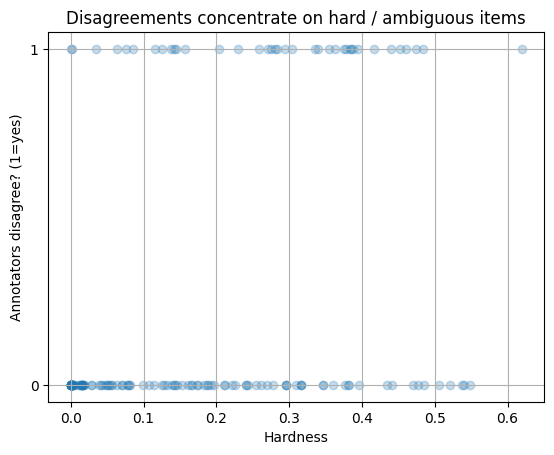

Disagreement rate: 0.25333333333333335


In [7]:
# Repeat labeling simulation + Cohen's kappa
proba_train = base_model.predict_proba(X_train)
hardness = 1.0 - np.max(proba_train, axis=1)

def cohens_kappa(a, b):
    a = np.asarray(a)
    b = np.asarray(b)
    classes = np.unique(np.concatenate([a, b]))
    p_o = np.mean(a == b)
    p_e = 0.0
    for c in classes:
        p_e += np.mean(a == c) * np.mean(b == c)
    return 1.0 if p_e == 1 else (p_o - p_e) / (1 - p_e)

def simulate_annotator(y_true, hardness, base_error=0.03, extra_error=0.25, seed=0):
    rng = np.random.default_rng(seed)
    y_true = np.asarray(y_true)
    classes = np.unique(y_true)
    p_error = np.clip(base_error + extra_error * hardness, 0, 0.95)
    flip = rng.random(len(y_true)) < p_error
    y_obs = y_true.copy()
    for i in np.where(flip)[0]:
        other = classes[classes != y_true[i]]
        y_obs[i] = rng.choice(other)
    return y_obs, flip, p_error

ann_A, flip_A, pA = simulate_annotator(y_train, hardness, base_error=0.03, extra_error=0.20, seed=11)
ann_B, flip_B, pB = simulate_annotator(y_train, hardness, base_error=0.06, extra_error=0.35, seed=12)

kappa = cohens_kappa(ann_A, ann_B)
p_o = np.mean(ann_A == ann_B)

print(f"Observed agreement p_o: {p_o:.4f}")
print(f"Cohen's kappa:        {kappa:.4f}")

disagree = (ann_A != ann_B)

plt.figure()
plt.hist(hardness, bins=30)
plt.title("Hardness distribution (1 - max predicted probability)")
plt.xlabel("Hardness")
plt.ylabel("Count")
plt.show()

plt.figure()
plt.scatter(hardness, disagree.astype(int), alpha=0.25)
plt.xlabel("Hardness")
plt.ylabel("Annotators disagree? (1=yes)")
plt.title("Disagreements concentrate on hard / ambiguous items")
plt.yticks([0, 1])
plt.grid(True)
plt.show()

print("Disagreement rate:", disagree.mean())


In [8]:
# Audit queue + consensus label (third annotator on disagreements)
ann_C, flip_C, pC = simulate_annotator(y_train, hardness, base_error=0.04, extra_error=0.25, seed=13)

consensus = ann_A.copy()
need_third = (ann_A != ann_B)
consensus[need_third] = ann_C[need_third]

audit = pd.DataFrame({
    "y_A": ann_A,
    "y_B": ann_B,
    "agree": ann_A == ann_B,
    "hardness": hardness,
})
audit["priority"] = 0.7 * audit["hardness"] + 0.3 * (~audit["agree"]).astype(float)

print("Fraction needing third label:", need_third.mean())
display(audit.sort_values("priority", ascending=False).head(12))

def train_eval(y_train_variant):
    m = Pipeline([("pre", pre), ("lr", LogisticRegression(max_iter=3000))])
    m.fit(X_train, y_train_variant)
    pred = m.predict(X_test)
    return accuracy_score(y_test, pred), pred

acc_A, pred_A = train_eval(ann_A)
acc_C, pred_C = train_eval(consensus)

print(f"Test accuracy (train labels = A-only):    {acc_A:.4f}")
print(f"Test accuracy (train labels = consensus): {acc_C:.4f}")


Fraction needing third label: 0.25333333333333335


,y_A,y_B,agree,hardness,priority
2,drugB,DrugY,False,0.619270,0.733489
78,drugX,drugB,False,0.484205,0.638944
33,DrugY,drugB,False,0.474154,0.631908
117,drugC,drugB,False,0.460865,0.622606
110,DrugY,drugA,False,0.451697,0.616188
59,drugA,drugB,False,0.439405,0.607583
40,DrugY,drugX,False,0.416463,0.591524
139,drugB,drugX,False,0.394922,0.576446
24,drugB,drugX,False,0.388133,0.571693
122,drugB,DrugY,False,0.384334,0.569034


Test accuracy (train labels = A-only):    0.9000
Test accuracy (train labels = consensus): 0.9600


,y_A,y_B,agree,hardness,priority,nll,disagree
3,drugA,DrugY,False,0.000062,0.300043,5.474249,True
105,drugC,DrugY,False,0.075857,0.353100,3.950951,True
88,drugC,DrugY,False,0.304554,0.513188,2.933792,True
47,drugB,DrugY,False,0.137363,0.396154,2.497486,True
137,DrugY,drugX,False,0.229716,0.460801,2.464227,True
60,drugA,drugC,False,0.274743,0.492320,2.092907,True
117,drugC,drugB,False,0.460865,0.622606,1.965170,True
69,drugB,drugA,False,0.142191,0.399534,1.817925,True
53,drugB,drugA,False,0.280860,0.496602,1.680816,True
6,DrugY,drugC,False,0.375166,0.562616,1.656498,True


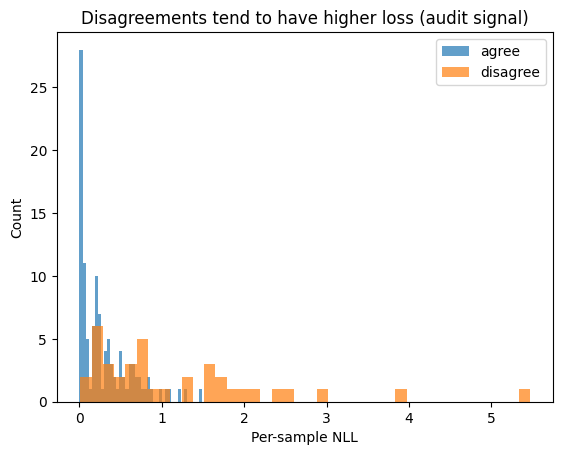

drop=0.00 keep_rate=1.000 -> test_acc=0.9000
drop=0.02 keep_rate=0.980 -> test_acc=0.9000
drop=0.05 keep_rate=0.947 -> test_acc=0.9200
drop=0.10 keep_rate=0.900 -> test_acc=0.9600


In [9]:
# Model-based audit: per-sample NLL; drop high-loss points and retrain
mA = Pipeline([("pre", pre), ("lr", LogisticRegression(max_iter=3000))])
mA.fit(X_train, ann_A)

proba = mA.predict_proba(X_train)
classes = mA.named_steps["lr"].classes_
idx = {c:i for i,c in enumerate(classes)}
y_idx = np.array([idx[c] for c in ann_A])

eps = 1e-12
nll = -np.log(np.clip(proba[np.arange(len(proba)), y_idx], eps, 1.0))

audit2 = audit.copy()
audit2["nll"] = nll
audit2["disagree"] = (ann_A != ann_B)

display(audit2.sort_values("nll", ascending=False).head(12))

plt.figure()
plt.hist(audit2.loc[~audit2["disagree"], "nll"], bins=40, alpha=0.7, label="agree")
plt.hist(audit2.loc[audit2["disagree"], "nll"], bins=40, alpha=0.7, label="disagree")
plt.xlabel("Per-sample NLL")
plt.ylabel("Count")
plt.title("Disagreements tend to have higher loss (audit signal)")
plt.legend()
plt.show()

def filter_and_retrain(drop_frac=0.05):
    cutoff = np.quantile(nll, 1 - drop_frac)
    keep = nll <= cutoff
    m = Pipeline([("pre", pre), ("lr", LogisticRegression(max_iter=3000))])
    m.fit(X_train.loc[keep], ann_A[keep])
    acc = accuracy_score(y_test, m.predict(X_test))
    return acc, keep.mean()

for q in [0.0, 0.02, 0.05, 0.10]:
    acc, keep_rate = filter_and_retrain(drop_frac=q)
    print(f"drop={q:>4.2f} keep_rate={keep_rate:>5.3f} -> test_acc={acc:.4f}")


Accuracy (clean-trained): 1.0
Accuracy (noisy-trained): 0.9947916666666666
AUC (clean-trained): 1.0
AUC (noisy-trained): 1.0


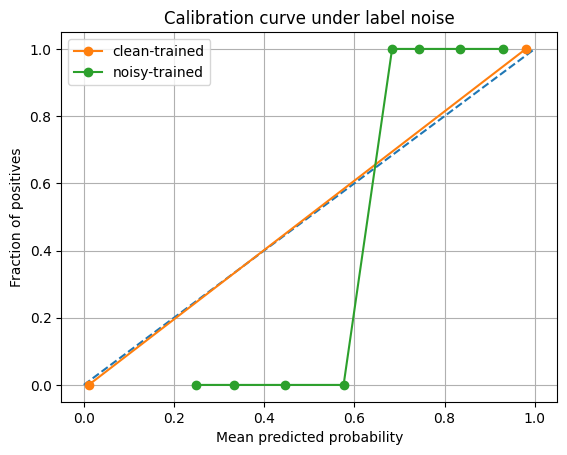

In [10]:
# Binary: calibration + AUC under label noise
dfb = df_bin.copy()
tgt = meta_bin["target"]

if bin_key == "wine_quality":
    dfb["good"] = (dfb["quality"].astype(int) >= 7).astype(int)
    tgt = "good"
elif bin_key == "diabetes":
    dfb["y01"] = dfb["classification"].astype(str).map({"Non-Diabetic": 0, "Diabetic": 1}).astype(int)
    tgt = "y01"
elif bin_key == "complaints":
    dfb["y01"] = dfb["Timely Response"].astype(str).map({"No": 0, "Yes": 1}).fillna(0).astype(int)
    tgt = "y01"

Xb = dfb.drop(columns=[tgt])
yb = dfb[tgt].astype(int)

num_b, cat_b = split_cols(Xb)

pre_b = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("sc", StandardScaler())]), num_b),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_b),
    ],
    remainder="drop"
)

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
    Xb, yb, test_size=0.25, random_state=42, stratify=yb
)

y_train_noisy, _ = inject_binary_flip(y_train_b, noise_rate=0.25, seed=77)

clf_clean = Pipeline([("pre", pre_b), ("lr", LogisticRegression(max_iter=3000))])
clf_noisy = Pipeline([("pre", pre_b), ("lr", LogisticRegression(max_iter=3000))])

clf_clean.fit(X_train_b, y_train_b)
clf_noisy.fit(X_train_b, y_train_noisy)

p_clean = clf_clean.predict_proba(X_test_b)[:, 1]
p_noisy = clf_noisy.predict_proba(X_test_b)[:, 1]

print("Accuracy (clean-trained):", accuracy_score(y_test_b, (p_clean >= 0.5).astype(int)))
print("Accuracy (noisy-trained):", accuracy_score(y_test_b, (p_noisy >= 0.5).astype(int)))
print("AUC (clean-trained):", roc_auc_score(y_test_b, p_clean))
print("AUC (noisy-trained):", roc_auc_score(y_test_b, p_noisy))

tc, pc = calibration_curve(y_test_b, p_clean, n_bins=10)
tn, pn = calibration_curve(y_test_b, p_noisy, n_bins=10)

plt.figure()
plt.plot([0,1],[0,1], linestyle="--")
plt.plot(pc, tc, marker="o", label="clean-trained")
plt.plot(pn, tn, marker="o", label="noisy-trained")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration curve under label noise")
plt.legend()
plt.grid(True)
plt.show()


sigma_scale=0.00 -> test_acc=1.0000
sigma_scale=0.05 -> test_acc=1.0000
sigma_scale=0.10 -> test_acc=1.0000
sigma_scale=0.20 -> test_acc=1.0000
sigma_scale=0.35 -> test_acc=1.0000


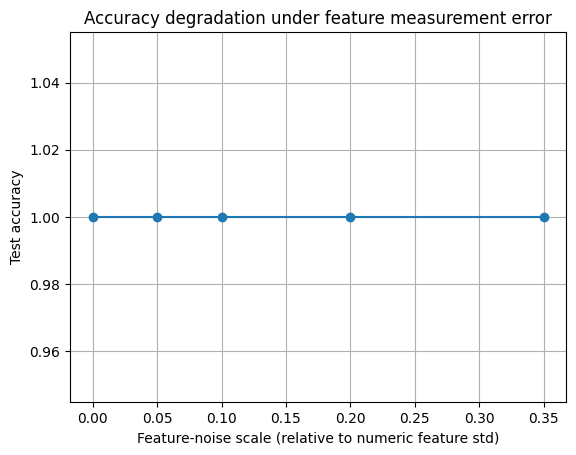

In [11]:
# Feature measurement error: degrade classification accuracy by adding noise to numeric columns
def add_feature_noise(X, num_cols, sigma_scale=0.10, seed=0):
    rng = np.random.default_rng(seed)
    Xn = X.copy()
    for col in num_cols:
        col_std = float(pd.to_numeric(Xn[col], errors="coerce").std(ddof=0))
        sigma = sigma_scale * (col_std if np.isfinite(col_std) and col_std > 0 else 1.0)
        Xn[col] = pd.to_numeric(Xn[col], errors="coerce") + rng.normal(0, sigma, size=len(Xn))
    return Xn

sigmas = [0.0, 0.05, 0.10, 0.20, 0.35]
accs = []

for s in sigmas:
    X_train_n = add_feature_noise(X_train_b, num_b, sigma_scale=s, seed=1)
    X_test_n  = add_feature_noise(X_test_b,  num_b, sigma_scale=s, seed=2)

    m = Pipeline([("pre", pre_b), ("lr", LogisticRegression(max_iter=3000))])
    m.fit(X_train_n, y_train_b)
    p = m.predict_proba(X_test_n)[:, 1]
    acc = accuracy_score(y_test_b, (p >= 0.5).astype(int))
    accs.append(acc)
    print(f"sigma_scale={s:>4.2f} -> test_acc={acc:.4f}")

plt.figure()
plt.plot(sigmas, accs, marker="o")
plt.xlabel("Feature-noise scale (relative to numeric feature std)")
plt.ylabel("Test accuracy")
plt.title("Accuracy degradation under feature measurement error")
plt.grid(True)
plt.show()


Chosen numeric feature for measurement error experiment: SqFt
sigma=   0.0 | RMSE=10,277.33 | coef(SqFt)=73.666
sigma=  10.0 | RMSE=10,310.38 | coef(SqFt)=74.746
sigma=  25.0 | RMSE=10,316.12 | coef(SqFt)=75.647
sigma=  50.0 | RMSE=10,216.14 | coef(SqFt)=75.218
sigma= 100.0 | RMSE=9,803.11 | coef(SqFt)=68.440


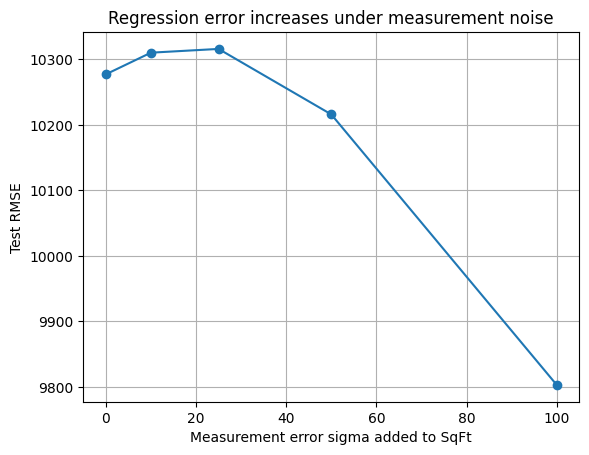

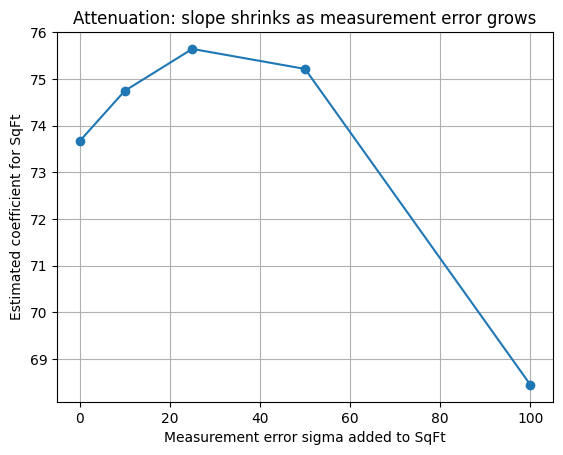

In [12]:
# Regression attenuation: slope shrinks as measurement error grows
dfr = df_reg.copy()
tgt_r = meta_reg["target"]

Xr = dfr.drop(columns=[tgt_r])
yr = dfr[tgt_r].astype(float)

num_r, cat_r = split_cols(Xr)

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(Xr, yr, test_size=0.25, random_state=42)

feat = "SqFt" if "SqFt" in num_r else (num_r[0] if len(num_r) else None)
print("Chosen numeric feature for measurement error experiment:", feat)

def add_measurement_error_df(X, col, sigma, seed=0):
    rng = np.random.default_rng(seed)
    Xn = X.copy()
    Xn[col] = pd.to_numeric(Xn[col], errors="coerce") + rng.normal(0, sigma, size=len(Xn))
    return Xn

pre_r = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_r),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_r),
    ],
    remainder="drop"
)

sigmas = [0.0, 10.0, 25.0, 50.0, 100.0]
rmse_list, coef_list = [], []

for s in sigmas:
    Xn_train = add_measurement_error_df(X_train_r, feat, sigma=s, seed=10)

    lr_full = Pipeline([("pre", pre_r), ("lr", LinearRegression())])
    lr_full.fit(Xn_train, y_train_r)
    pred = lr_full.predict(X_test_r)

    rmse = math.sqrt(mean_squared_error(y_test_r, pred))
    rmse_list.append(rmse)

    if feat is not None:
        lr_num = LinearRegression().fit(Xn_train[num_r], y_train_r)
        coef = lr_num.coef_[num_r.index(feat)]
    else:
        coef = float("nan")
    coef_list.append(coef)

    print(f"sigma={s:>6.1f} | RMSE={rmse:,.2f} | coef({feat})={coef:,.3f}")

plt.figure()
plt.plot(sigmas, rmse_list, marker="o")
plt.xlabel(f"Measurement error sigma added to {feat}")
plt.ylabel("Test RMSE")
plt.title("Regression error increases under measurement noise")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(sigmas, coef_list, marker="o")
plt.xlabel(f"Measurement error sigma added to {feat}")
plt.ylabel(f"Estimated coefficient for {feat}")
plt.title("Attenuation: slope shrinks as measurement error grows")
plt.grid(True)
plt.show()


### Summary and takeaways

- Label noise, ambiguity, and measurement error are different failure modes; diagnosing the wrong one leads to wasted effort.
- Agreement metrics (e.g., $\kappa$) quantify ambiguity and guideline quality.
- Disagreements and high-loss points provide actionable audit queues.
- Noise can harm calibration and AUC even when accuracy looks acceptable.
- Measurement error can attenuate regression slopes and reduce classification separability.

### Exercises

1. Increase annotator difficulty sensitivity in `simulate_annotator` and observe how $\kappa$ changes.
2. Change audit priority weights and compare the top-20 queue.
3. Compare dropping high-loss points vs simulating corrected labels for those points and retraining.
4. In regression, estimate an empirical attenuation ratio:
$$
\rho = \frac{\hat{\beta}^{*}}{\hat{\beta}}
$$
by comparing the slope at `sigma=0` and `sigma>0`.
